In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, learning_curve, train_test_split

In [3]:
df = pd.read_csv("./data.csv")
df.drop(["Unnamed: 0"], inplace=True, axis=1)
df

,30,45,60,90,120,135,150,speed,label
0,1.497866,-0.156357,-0.730413,-1.140428,-0.805707,-0.156357,1.491395,0,0
1,1.442252,-0.169266,-0.728503,-1.127933,-0.801854,-0.169266,1.554570,0,0
2,1.497866,-0.156357,-0.730413,-1.140428,-0.805707,-0.156357,1.491395,0,0
3,1.497866,-0.156357,-0.730413,-1.140428,-0.805707,-0.156357,1.491395,0,0
4,1.480616,-0.167738,-0.747360,-1.173858,-0.747360,-0.148480,1.504180,23,1
...,...,...,...,...,...,...,...,...,...
29050,1.395053,-0.045195,-0.808261,-1.203214,-0.808261,-0.045195,1.515073,358,4
29051,1.463368,-0.065307,-0.801349,-1.193423,-0.801349,-0.065307,1.463368,367,4
29052,1.286868,-0.089803,-0.800793,-1.205045,-0.800793,-0.003265,1.612830,323,4
29053,1.367514,-0.096175,-0.805693,-1.215923,-0.757765,-0.046524,1.554566,323,4


In [4]:
labels = np.array(df["label"])
data = np.array(df[["30", "45", "60", "90", "120", "135", "150", "speed"]])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

# KNN

In [6]:
KNN = KNeighborsClassifier()

KNN.fit(X_train, y_train)

KNN.score(X_test, y_test)

0.38523307957034103

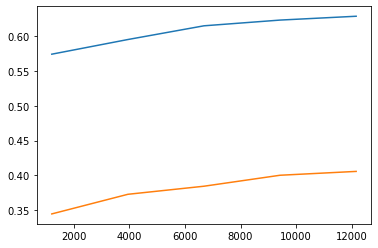

In [94]:
training_examples, train_score, valid_score = learning_curve(KNN, X_train, y_train, cv=StratifiedKFold(3))
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

In [12]:
KNN = KNeighborsClassifier()
params = {
    'KNN__n_neighbors': [3, 5, 7],
    'KNN__algorithm': ["ball_tree", "kd_tree"],
    'KNN__leaf_size': [8, 16, 32],
    'KNN__metric': ["euclidean", "minkowski", "manhattan"],
    'KNN__p': [1, 2],
}

imp = SimpleImputer(missing_values=np.nan, strategy="mean")
pipe = Pipeline(steps=[("imputer", imp), ("KNN", KNN)])

grid = GridSearchCV(pipe, params, scoring="accuracy", cv=StratifiedKFold(3), verbose=1)
grid.fit(X_train, y_train)

print(grid.cv_results_)

{'mean_fit_time': array([0.01333102, 0.01333372, 0.01365527, 0.01293778, 0.01421364,
       0.01564749, 0.01329788, 0.01296401, 0.01364398, 0.01562277,
       0.01530186, 0.01993378, 0.01663319, 0.01396163, 0.01396243,
       0.0149591 , 0.01961517, 0.02011887, 0.01660506, 0.01214981,
       0.01195757, 0.01197823, 0.01224661, 0.01297752, 0.01195566,
       0.01361322, 0.01263452, 0.01230558, 0.01363007, 0.0122989 ,
       0.01262863, 0.01812204, 0.01883602, 0.01861811, 0.0189476 ,
       0.0208923 , 0.01695752, 0.01775511, 0.01779477, 0.01630457,
       0.01758297, 0.01767055, 0.01482201, 0.01130176, 0.01495918,
       0.01065071, 0.01162354, 0.01096932, 0.01114027, 0.01097147,
       0.01163999, 0.01217198, 0.01198212, 0.01230502, 0.01994824,
       0.02027973, 0.01996017, 0.01995842, 0.0199465 , 0.01930809,
       0.01914446, 0.01994602, 0.01928123, 0.01961613, 0.01915606,
       0.01927018, 0.02127473, 0.03096024, 0.02991883, 0.03257807,
       0.03058505, 0.03004281, 0.02499779, 0

In [14]:
print(grid.best_estimator_)
print(grid.score(X_test, y_test))

Pipeline(steps=[('imputer', SimpleImputer()),
                ('KNN',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=8,
                                      n_neighbors=7, p=1))])
0.39065595995411406


# RF

In [54]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

rf.score(X_test, y_test)

0.6115055963413166

In [29]:
np.unique(rf.predict(X_test), return_counts=True)

(array([0, 1, 2, 3, 5, 6, 7], dtype=int64),
 array([2501, 1459,   62,   12,   35,  105, 1298], dtype=int64))

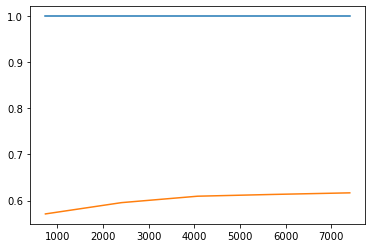

In [28]:
training_examples, train_score, valid_score = learning_curve(rf, X_train, y_train, cv=StratifiedKFold(3))
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

In [97]:
rf = RandomForestClassifier()
params = {
    'RF__n_estimators': [50, 100, 150],
    'RF__criterion': ["gini", "log_loss", "entropy"],
    'RF__max_depth': [None, 5, 10],
    'RF__max_features': ["sqrt", "log2", "None"],
    'RF__max_leaf_nodes': [None, 8, 10, 16, 32],
}

imp = SimpleImputer(missing_values=np.nan, strategy="mean")
pipe = Pipeline(steps=[("imputer", imp), ("RF", rf)])

grid = GridSearchCV(pipe, params, scoring="accuracy", cv=StratifiedKFold(3))
grid.fit(X_train, y_train)

print(grid.cv_results_)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


C:\Users\wilso\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\wilso\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\wilso\anaconda3\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\wilso\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\wilso\anaconda3\li

{'mean_fit_time': array([0.72794477, 1.44751048, 2.19249137, 0.28718146, 0.57310406,
       0.84656199, 0.30198185, 0.5977265 , 0.89306974, 0.33562771,
       0.66495848, 1.0157148 , 0.37785912, 0.7583789 , 1.15031258,
       0.96818209, 2.06176678, 3.1631705 , 0.42598764, 0.84141421,
       1.21516792, 0.42808986, 0.8537244 , 1.27877649, 0.49467397,
       1.0037291 , 1.46023075, 0.55903109, 1.10826222, 1.69062392,
       0.01826914, 0.03292394, 0.04754011, 0.01895078, 0.03324517,
       0.04658294, 0.01926796, 0.03424199, 0.04942576, 0.01860404,
       0.03242477, 0.05485733, 0.01828432, 0.0315938 , 0.04587777,
       0.35339872, 0.6950895 , 1.05254261, 0.30447006, 0.63392925,
       0.89273151, 0.3111736 , 0.61315608, 0.92641234, 0.33846807,
       0.66922998, 1.02192426, 0.34200454, 0.68355966, 1.02912935,
       0.46845007, 0.92132823, 1.41431626, 0.39879529, 0.79932984,
       1.20056454, 0.41629918, 0.85407925, 1.25005293, 0.4518319 ,
       0.94217912, 1.38925354, 0.46906447, 0

In [98]:
grid.score(X_test, y_test)

0.618421052631579

In [105]:
print(grid.predict(X_test))
print(y_test)

[0 1 7 ... 0 1 7]
[0 0 0 ... 0 3 7]


# SVM

In [12]:
svm = SVC()
svm.fit(X_train, y_train)

svm.score(X_test, y_test)

0.34539576598185423

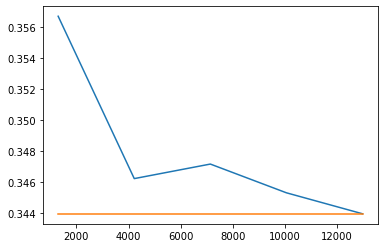

In [13]:
training_examples, train_score, valid_score = learning_curve(svm, X_train, y_train, cv=StratifiedKFold(3))
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

In [6]:
imp = SimpleImputer(missing_values=np.nan, strategy="mean")

In [7]:
# Non-linear
svm = SVC()

params = {
    'SVM__C': [0.01, 0.1, 1, 2, 5],
    'SVM__kernel': ["rbf", "sigmoid"],
    'SVM__gamma': ["scale", "auto"],
    'SVM__class_weight': ["balanced"],
}

# imp = SimpleImputer(missing_values=np.nan, strategy="mean")
pipe = Pipeline(steps=[("imputer", imp), ("SVM", svm)])

rscv = RandomizedSearchCV(pipe, params, scoring="accuracy", cv=StratifiedKFold(3), n_iter=8)
rscv.fit(X_train, y_train)

print(rscv.cv_results_)

{'mean_fit_time': array([13.19330668, 17.91954517, 17.77461116, 11.37800129, 10.17008464,
       21.50481876, 31.86023172, 21.16573771]), 'std_fit_time': array([0.13133679, 0.10597168, 0.06772175, 0.95809099, 0.13336032,
       1.74820163, 3.75132773, 0.04419573]), 'mean_score_time': array([ 2.31475504,  7.93599423,  7.90270933,  2.41259742,  3.43588726,
       10.9155941 , 11.24243339,  3.65832551]), 'std_score_time': array([0.00772791, 0.0266227 , 0.00689637, 0.03642538, 0.3196999 ,
       1.56441187, 1.53414897, 0.00835811]), 'param_SVM__kernel': masked_array(data=['sigmoid', 'rbf', 'rbf', 'sigmoid', 'sigmoid', 'rbf',
                   'rbf', 'sigmoid'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_SVM__gamma': masked_array(data=['auto', 'scale', 'scale', 'auto', 'scale', 'auto',
                   'auto', 'scale'],
             mask=[False, False, False, False, False, False, False, False],
    

In [10]:
print(rscv.best_estimator_)
print(rscv.score(X_test, y_test))

Pipeline(steps=[('imputer', SimpleImputer()),
                ('SVM', SVC(C=5, class_weight='balanced', gamma='auto'))])
0.24538533736573157


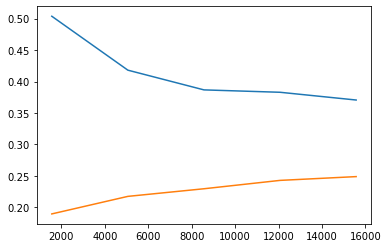

In [12]:
training_examples, train_score, valid_score = learning_curve(rscv.best_estimator_[1], X_train, y_train)
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

In [9]:
# Linear
svm_l2 = LinearSVC()

params = {
    'SVM__C': [0.01, 0.1, 1, 2, 5],
    'SVM__penalty': ["l2"],
    'SVM__loss': ["hinge", "squared_hinge"],
    'SVM__class_weight': ["balanced"],
    'SVM__max_iter': [100000],
    'SVM__tol': [1e-4],
}

# imp = SimpleImputer(missing_values=np.nan, strategy="mean")
pipe_l2 = Pipeline(steps=[("imputer", imp), ("SVM", svm_l2)])

grid_l2 = GridSearchCV(pipe_l2, params, scoring="accuracy", cv=StratifiedKFold(3), error_score="raise")
grid_l2.fit(X_train, y_train)

print(grid_l2.cv_results_)

C:\Users\wilso\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\wilso\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\wilso\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\wilso\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\wilso\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\wilso\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number 

{'mean_fit_time': array([ 40.58743636, 415.12259356, 208.00126537, 567.4912502 ,
       434.60804152, 476.03067493, 468.46382332, 477.04781508,
       486.28958686, 474.72887969]), 'std_fit_time': array([ 5.16882652, 13.90603618,  9.04242661, 58.86941407,  2.74913873,
        2.70186177,  2.87085429,  0.81638131,  2.91632008,  2.49610405]), 'mean_score_time': array([0.00230575, 0.00267212, 0.0030334 , 0.00232712, 0.00198285,
       0.00219552, 0.00210436, 0.00235105, 0.00232665, 0.00262459]), 'std_score_time': array([4.65518162e-04, 4.80025454e-04, 3.72792945e-05, 4.69572250e-04,
       1.63014314e-05, 6.05227972e-04, 1.75409798e-04, 5.31401194e-04,
       4.69066336e-04, 4.93213318e-04]), 'param_SVM__C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1, 1, 2, 2, 5, 5],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_SVM__class_weight': masked_array(data=['balanced', 'balance

C:\Users\wilso\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [10]:
print(grid_l2.best_estimator_)
print(grid_l2.score(X_test, y_test))

Pipeline(steps=[('imputer', SimpleImputer()),
                ('SVM',
                 LinearSVC(C=5, class_weight='balanced', max_iter=100000))])
0.3596829700698717


In [6]:
# Linear
svm_l1 = LinearSVC()

params = {
    'SVM__C': [0.01, 0.1, 1, 2, 5],
    'SVM__penalty': ["l1"],
    'SVM__dual': [False],
    'SVM__loss': ["squared_hinge"],
    'SVM__class_weight': ["balanced"],
    'SVM__max_iter': [100000],
    'SVM__tol': [1e-4],
}

# imp = SimpleImputer(missing_values=np.nan, strategy="mean")
pipe_l1 = Pipeline(steps=[("imputer", imp), ("SVM", svm_l1)])

grid_l1 = GridSearchCV(pipe_l1, params, scoring="accuracy", cv=StratifiedKFold(3), error_score="raise")
grid_l1.fit(X_train, y_train)

print(grid_l1.cv_results_)

{'mean_fit_time': array([ 1.14047273,  5.53292743, 26.96769849, 23.05977241, 11.7703774 ]), 'std_fit_time': array([ 0.16874372,  0.30930244,  3.61307085, 16.58166695,  6.64639098]), 'mean_score_time': array([0.00253542, 0.00178464, 0.00231481, 0.00298047, 0.00199278]), 'std_score_time': array([1.55313909e-03, 8.57318917e-04, 4.78342699e-04, 1.52003141e-05,
       8.30534678e-04]), 'param_SVM__C': masked_array(data=[0.01, 0.1, 1, 2, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_SVM__class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                   'balanced'],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_SVM__dual': masked_array(data=[False, False, False, False, False],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_SVM__loss': masked_array(data=['square

In [7]:
print(grid_l1.best_estimator_)
print(grid_l1.score(X_test, y_test))

Pipeline(steps=[('imputer', SimpleImputer()),
                ('SVM',
                 LinearSVC(C=2, class_weight='balanced', dual=False,
                           max_iter=100000, penalty='l1'))])
0.43320471373448743


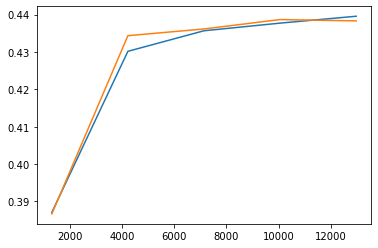

In [5]:
training_examples, train_score, valid_score = learning_curve(LinearSVC(C=2, class_weight='balanced', dual=False,max_iter=100000, penalty='l1'), 
                                                             X_train, y_train, cv=StratifiedKFold(3))
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

# Neural Nets

In [2]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(8, )))
#     for i in range(hp.Int("n_layers", 1, 3)):
    model.add(Dense(hp.Int("n_neurons", 64, 208, 16), activation="softmax"))
    model.add(Dense(5, activation="softmax"))
    
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
    hp_beta_1 = hp.Choice("beta_1", values=[0.9, 0.85, 0.95])
    hp_beta_2 = hp.Choice("beta_2", values=[0.999, 0.99, 0.9999])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

In [34]:
def build_model_a(act="softmax", opt=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)):
    model = tf.keras.Sequential()
    model.add(Dense(208, activation=act, input_shape=(8, )))
    model.add(Dense(8, activation=act))
    model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

In [48]:
def build_model_b(act="softmax", opt=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)):
    model = tf.keras.Sequential()
    model.add(Dense(96, activation=act, input_shape=(8, )))
    model.add(Dense(8, activation=act))
    model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

In [4]:
def build_model_c(act="softmax", opt=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.99)):
    model = tf.keras.Sequential()
    model.add(Dense(196, activation=act, input_shape=(8, )))
    model.add(Dense(8, activation=act))
    model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)
tuner = RandomSearch(build_model, objective="val_accuracy", max_trials=100, project_name="no_back", overwrite=False)
tuner.search(x=X_train, y=y_train, epochs=120, batch_size=10, validation_data=(X_test, y_test), callbacks=[callback])

Trial 101 Complete [00h 01m 24s]
val_accuracy: 0.41184258460998535

Best val_accuracy So Far: 0.5853893160820007
Total elapsed time: 02h 56m 46s
INFO:tensorflow:Oracle triggered exit


In [20]:
tuner.results_summary()

Results summary
Results in .\no_back
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
n_neurons: 192
learning_rate: 0.001
beta_1: 0.95
beta_2: 0.999
Score: 0.5853893160820007
Trial summary
Hyperparameters:
n_neurons: 208
learning_rate: 0.001
beta_1: 0.9
beta_2: 0.999
Score: 0.5838247537612915
Trial summary
Hyperparameters:
n_neurons: 96
learning_rate: 0.001
beta_1: 0.9
beta_2: 0.999
Score: 0.5831026434898376
Trial summary
Hyperparameters:
n_neurons: 128
learning_rate: 0.001
beta_1: 0.95
beta_2: 0.9999
Score: 0.5826212763786316
Trial summary
Hyperparameters:
n_neurons: 112
learning_rate: 0.001
beta_1: 0.9
beta_2: 0.9999
Score: 0.5797328352928162
Trial summary
Hyperparameters:
n_neurons: 96
learning_rate: 0.001
beta_1: 0.9
beta_2: 0.99
Score: 0.5793717503547668
Trial summary
Hyperparameters:
n_neurons: 80
learning_rate: 0.001
beta_1: 0.95
beta_2: 0.999
Score: 0.578649640083313
Trial summary
Hyperparameters:
n_neurons: 160
learning_rate

In [22]:
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)

In [23]:
history = model.fit(X_train, y_train, epochs=400, validation_split=0.2)

Epoch 1/400
422/422 [==============================] - 2s 4ms/step - loss: 1.4723 - accuracy: 0.4008 - val_loss: 1.4240 - val_accuracy: 0.4132
Epoch 2/400
422/422 [==============================] - 1s 3ms/step - loss: 1.4116 - accuracy: 0.4149 - val_loss: 1.4121 - val_accuracy: 0.4132
Epoch 3/400
422/422 [==============================] - 1s 3ms/step - loss: 1.4051 - accuracy: 0.4149 - val_loss: 1.4113 - val_accuracy: 0.4132
Epoch 4/400
422/422 [==============================] - 1s 3ms/step - loss: 1.3962 - accuracy: 0.4150 - val_loss: 1.3879 - val_accuracy: 0.4135
Epoch 5/400
422/422 [==============================] - 1s 3ms/step - loss: 1.3735 - accuracy: 0.4191 - val_loss: 1.3587 - val_accuracy: 0.4253
Epoch 6/400
422/422 [==============================] - 1s 3ms/step - loss: 1.3458 - accuracy: 0.4352 - val_loss: 1.3298 - val_accuracy: 0.4455
Epoch 7/400
422/422 [==============================] - 1s 3ms/step - loss: 1.3184 - accuracy: 0.4523 - val_loss: 1.3134 - val_accuracy: 0.4748

In [24]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "test"], loc="lower right")
plt.show()

val_acc_epoch = history.history["val_accuracy"]
best_epoch = val_acc_epoch.index(max(val_acc_epoch)) + 1

In [25]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/174
422/422 [==============================] - 2s 4ms/step - loss: 1.4657 - accuracy: 0.3993 - val_loss: 1.4206 - val_accuracy: 0.4132
Epoch 2/174
422/422 [==============================] - 2s 4ms/step - loss: 1.4106 - accuracy: 0.4149 - val_loss: 1.4122 - val_accuracy: 0.4132
Epoch 3/174
422/422 [==============================] - 2s 4ms/step - loss: 1.4058 - accuracy: 0.4149 - val_loss: 1.4140 - val_accuracy: 0.4132
Epoch 4/174
422/422 [==============================] - 2s 4ms/step - loss: 1.4022 - accuracy: 0.4149 - val_loss: 1.4100 - val_accuracy: 0.4132
Epoch 5/174
422/422 [==============================] - 2s 4ms/step - loss: 1.3991 - accuracy: 0.4149 - val_loss: 1.4013 - val_accuracy: 0.4132
Epoch 6/174
422/422 [==============================] - 2s 4ms/step - loss: 1.3871 - accuracy: 0.4151 - val_loss: 1.3862 - val_accuracy: 0.4111
Epoch 7/174
422/422 [==============================] - 2s 4ms/step - loss: 1.3576 - accuracy: 0.4162 - val_loss: 1.3393 - val_accuracy: 0.4123

In [31]:
print(np.unique(np.argmax(model.predict(X_test), axis=1), return_counts=True))
print(np.unique(y_test, return_counts=True))
print(np.unique(y_train, return_counts=True))

260/260 [==============================] - 0s 1ms/step
(array([0, 1, 2, 3], dtype=int64), array([4337, 1962,    4, 2006], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([3422, 1974,  601, 1734,  578], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([6993, 3910, 1197, 3571, 1197], dtype=int64))


In [32]:
accuracy_score(y_test, np.argmax(model.predict(X_test), axis=1))

260/260 [==============================] - 0s 1ms/step


0.5744373570826814

In [24]:
model.save("./model_d.h5")

In [33]:
tuner.results_summary()

Results summary
Results in .\no_back
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
n_neurons: 192
learning_rate: 0.001
beta_1: 0.95
beta_2: 0.999
Score: 0.5853893160820007
Trial summary
Hyperparameters:
n_neurons: 208
learning_rate: 0.001
beta_1: 0.9
beta_2: 0.999
Score: 0.5838247537612915
Trial summary
Hyperparameters:
n_neurons: 96
learning_rate: 0.001
beta_1: 0.9
beta_2: 0.999
Score: 0.5831026434898376
Trial summary
Hyperparameters:
n_neurons: 128
learning_rate: 0.001
beta_1: 0.95
beta_2: 0.9999
Score: 0.5826212763786316
Trial summary
Hyperparameters:
n_neurons: 112
learning_rate: 0.001
beta_1: 0.9
beta_2: 0.9999
Score: 0.5797328352928162
Trial summary
Hyperparameters:
n_neurons: 96
learning_rate: 0.001
beta_1: 0.9
beta_2: 0.99
Score: 0.5793717503547668
Trial summary
Hyperparameters:
n_neurons: 80
learning_rate: 0.001
beta_1: 0.95
beta_2: 0.999
Score: 0.578649640083313
Trial summary
Hyperparameters:
n_neurons: 160
learning_rate

In [50]:
model_a = build_model_a()
model_b = build_model_b()

hist1 = model_a.fit(X_train, y_train, epochs=250, validation_split=0.2)
hist2 = model_b.fit(X_train, y_train, epochs=250, validation_split=0.2)

Epoch 1/250
422/422 [==============================] - 3s 5ms/step - loss: 1.4226 - accuracy: 0.4108 - val_loss: 1.4114 - val_accuracy: 0.4132
Epoch 2/250
422/422 [==============================] - 1s 3ms/step - loss: 1.4066 - accuracy: 0.4149 - val_loss: 1.4110 - val_accuracy: 0.4132
Epoch 3/250
422/422 [==============================] - 1s 3ms/step - loss: 1.4057 - accuracy: 0.4149 - val_loss: 1.4086 - val_accuracy: 0.4132
Epoch 4/250
422/422 [==============================] - 1s 3ms/step - loss: 1.4001 - accuracy: 0.4149 - val_loss: 1.4019 - val_accuracy: 0.4132
Epoch 5/250
422/422 [==============================] - 1s 3ms/step - loss: 1.3840 - accuracy: 0.4149 - val_loss: 1.3733 - val_accuracy: 0.4132
Epoch 6/250
422/422 [==============================] - 1s 3ms/step - loss: 1.3560 - accuracy: 0.4180 - val_loss: 1.3400 - val_accuracy: 0.4188
Epoch 7/250
422/422 [==============================] - 1s 3ms/step - loss: 1.3265 - accuracy: 0.4301 - val_loss: 1.3116 - val_accuracy: 0.4431

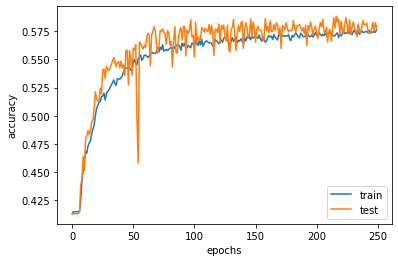

In [38]:
plt.plot(hist1.history["accuracy"], label="accuracy")
plt.plot(hist1.history["val_accuracy"], label="val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "test"], loc="lower right")
plt.show()

In [42]:
val_acc_epoch = hist1.history["val_accuracy"]
best_epoch = val_acc_epoch.index(max(val_acc_epoch)) + 1

model_a = build_model_a()
model_a.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/215
422/422 [==============================] - 2s 4ms/step - loss: 1.4207 - accuracy: 0.4149 - val_loss: 1.4119 - val_accuracy: 0.4132
Epoch 2/215
422/422 [==============================] - 1s 3ms/step - loss: 1.4064 - accuracy: 0.4149 - val_loss: 1.4111 - val_accuracy: 0.4132
Epoch 3/215
422/422 [==============================] - 1s 3ms/step - loss: 1.4048 - accuracy: 0.4149 - val_loss: 1.4080 - val_accuracy: 0.4132
Epoch 4/215
422/422 [==============================] - 1s 3ms/step - loss: 1.4016 - accuracy: 0.4149 - val_loss: 1.4096 - val_accuracy: 0.4132
Epoch 5/215
422/422 [==============================] - 1s 3ms/step - loss: 1.3985 - accuracy: 0.4149 - val_loss: 1.4065 - val_accuracy: 0.4132
Epoch 6/215
422/422 [==============================] - 1s 3ms/step - loss: 1.3967 - accuracy: 0.4149 - val_loss: 1.4017 - val_accuracy: 0.4132
Epoch 7/215
422/422 [==============================] - 1s 3ms/step - loss: 1.3908 - accuracy: 0.4160 - val_loss: 1.3958 - val_accuracy: 0.4152

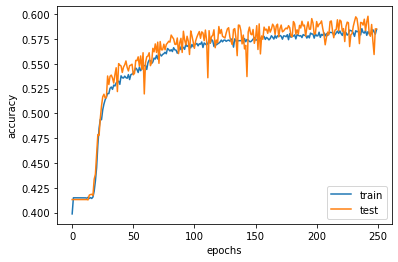

In [39]:
plt.plot(hist2.history["accuracy"], label="accuracy")
plt.plot(hist2.history["val_accuracy"], label="val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "test"], loc="lower right")
plt.show()

In [51]:
val_acc_epoch = hist2.history["val_accuracy"]
best_epoch = val_acc_epoch.index(max(val_acc_epoch)) + 1

model_b = build_model_b()
model_b.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/233
422/422 [==============================] - 3s 5ms/step - loss: 1.4190 - accuracy: 0.4147 - val_loss: 1.4108 - val_accuracy: 0.4132
Epoch 2/233
422/422 [==============================] - 2s 5ms/step - loss: 1.4057 - accuracy: 0.4137 - val_loss: 1.4083 - val_accuracy: 0.4132
Epoch 3/233
422/422 [==============================] - 2s 4ms/step - loss: 1.3986 - accuracy: 0.4157 - val_loss: 1.4137 - val_accuracy: 0.4132
Epoch 4/233
422/422 [==============================] - 2s 4ms/step - loss: 1.3964 - accuracy: 0.4183 - val_loss: 1.3964 - val_accuracy: 0.4241
Epoch 5/233
422/422 [==============================] - 2s 5ms/step - loss: 1.3888 - accuracy: 0.4223 - val_loss: 1.3921 - val_accuracy: 0.4185
Epoch 6/233
422/422 [==============================] - 2s 4ms/step - loss: 1.3813 - accuracy: 0.4303 - val_loss: 1.3834 - val_accuracy: 0.4203
Epoch 7/233
422/422 [==============================] - 2s 5ms/step - loss: 1.3678 - accuracy: 0.4391 - val_loss: 1.3593 - val_accuracy: 0.4422

In [53]:
print(model.evaluate(X_test, y_test))
print(model_a.evaluate(X_test, y_test))
print(model_b.evaluate(X_test, y_test))

260/260 [==============================] - 1s 3ms/step - loss: 1.0472 - accuracy: 0.5744
[1.0472266674041748, 0.5744373798370361]
260/260 [==============================] - 1s 2ms/step - loss: 1.0313 - accuracy: 0.5765
[1.0312726497650146, 0.5764833092689514]
260/260 [==============================] - 1s 2ms/step - loss: 1.0570 - accuracy: 0.5696
[1.0569791793823242, 0.5696232914924622]


In [47]:
print(np.unique(np.argmax(model_b.predict(X_test), axis=1), return_counts=True))

260/260 [==============================] - 0s 1ms/step
(array([0, 1, 2, 3, 4], dtype=int64), array([4389, 2241,    9, 1665,    5], dtype=int64))


In [55]:
mlp = MLPClassifier(max_iter=10000, learning_rate="adaptive")

mlp.fit(X_train, y_train)

mlp.score(X_test, y_test)

0.564087134432543

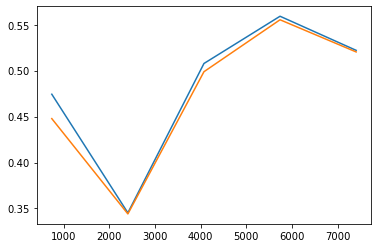

In [48]:
training_examples, train_score, valid_score = learning_curve(mlp, X_train, y_train, cv=StratifiedKFold(3))
plt.plot(training_examples, np.mean(train_score, axis=1), label="train_score")
plt.plot(training_examples, np.mean(valid_score, axis=1), label="valid_score")
plt.show()

In [49]:
np.unique(mlp.predict(X_test), return_counts=True)

(array([0, 1, 2, 6, 7], dtype=int64),
 array([2845, 1476,   13,   18, 1120], dtype=int64))

# Ensemble

In [100]:
a = KerasClassifier(build_model_a, epochs=400, batch_size=10)
a._estimator_type = "classifier"
b = KerasClassifier(build_model_b, epochs=400, batch_size=10)
b._estimator_type = "classifier"
c = KerasClassifier(build_model_c, epochs=400, batch_size=10)
c._estimator_type = "classifier"

<ipython-input-100-233bc4989a44>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  a = KerasClassifier(build_model_a, epochs=400, batch_size=10)
<ipython-input-100-233bc4989a44>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  b = KerasClassifier(build_model_b, epochs=400, batch_size=10)
<ipython-input-100-233bc4989a44>:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  c = KerasClassifier(build_model_c, epochs=400, batch_size=10)


In [101]:
ens = VotingClassifier([("a", a), ("b", b), ("c", c)], voting="hard", weights=[0.37, 0.33, 0.3])

In [102]:
ens.fit(X_train, y_train)

ens.score(X_test, y_test)

Epoch 1/400
1111/1111 [==============================] - 4s 3ms/step - loss: 1.5836 - accuracy: 0.3984
Epoch 2/400
1111/1111 [==============================] - 3s 3ms/step - loss: 1.5716 - accuracy: 0.3989
Epoch 3/400
1111/1111 [==============================] - 3s 3ms/step - loss: 1.5707 - accuracy: 0.3989
Epoch 4/400
1111/1111 [==============================] - 3s 3ms/step - loss: 1.5706 - accuracy: 0.3989
Epoch 5/400
1111/1111 [==============================] - 3s 3ms/step - loss: 1.5703 - accuracy: 0.3989
Epoch 6/400
1111/1111 [==============================] - 3s 3ms/step - loss: 1.5701 - accuracy: 0.3989
Epoch 7/400
1111/1111 [==============================] - 3s 3ms/step - loss: 1.5699 - accuracy: 0.3989
Epoch 8/400
1111/1111 [==============================] - 3s 3ms/step - loss: 1.5685 - accuracy: 0.3989
Epoch 9/400
1111/1111 [==============================] - 3s 3ms/step - loss: 1.5652 - accuracy: 0.3994
Epoch 10/400
1111/1111 [==============================] - 3s 3ms/step - l

0.5975877192982456

In [103]:
np.unique(ens.predict(X_test), return_counts=True)

171/171 [==============================] - 0s 939us/step


(array([0, 1, 2, 5, 6, 7], dtype=int64),
 array([2450, 1638,   12,    4,   61, 1307], dtype=int64))

In [104]:
print(ens.predict(X_test))
print(y_test)

171/171 [==============================] - 0s 932us/step
[0 1 1 ... 0 1 7]
[0 0 0 ... 0 3 7]
